In [1485]:
import random
import numpy as np

In [1486]:
class Set:
    def __init__(self, players, n = 10, winBonus = 10, roundBonus = 2, ordered = False, printMode = False):
        '''
        n (int) - number of rounds to be played per set
        players (1 x k numpy array) - numpy row slice of k player objects
        winBonus (int) - bonus awarded to the player who "takes" and therefore wins the Set
        roundBonus (int) - incremental bonus awarded for every round the set lasts
        ordered (bool) - True if order of players is given, False if order of players should be randomized
        k (int) - number of players for the set
        printMode (bool) - testing bool - used to print stuff out while game is going to make it look good
        
        
        Initialized later:
        
        playHist (k x n numpy array) - records actions for each player at every played round
        set_scores (k x 1 numpy array) - contains the calculated score for each player after set is played
        winner (int) - index of the player who "takes" and wins the set
        r_end (int) - round where a player decided to "take"
        plays_total (int) - the total number of actions taken in the set
        '''
        self.n = n
        self.players = players
        self.winBonus = winBonus
        self.roundBonus = roundBonus
        self.k = len(players)
        self.printMode = printMode
        
        # shuffle player order if not specified
        if not ordered:
            random.shuffle(self.players)
            
        
    def initialize_playHistory(self):
        '''
        Initialize the k x n playHistory array that will record the action in round r for player i in row i column r
        
        All actions that do not happen as a result of the game ending are NaN  -- (playHist)
        
        Also initializes each player's index for the set - index is used as row i in playHistory and set_scores
        
        Used in -play-
        '''
        self.playHist = np.empty((self.k, self.n))
        self.playHist[:] = np.NaN
        
        # initialize row/index for each player
        for idx, player in enumerate(self.players):
            player.idx = idx
            
            
    def record_actions(self, r):
        '''
        Records the action for each player in the playHistory array for one round. A 0 for row i column r represents
        a decision of pass for player i while a 1 represents a Take.
        
        Used in -play-
        '''
        
        for player in self.players:
            decision = player.run_strategy(r, self.n, self.k)
            #decision = player.manual_decision(r = r, n = self.n, k = self.k)
            #decision = player.rando_decision()
            if(decision == 'Pass'):
                self.playHist[player.idx][r] = 0
            elif(decision == 'Take'):
                self.playHist[player.idx][r] = 1
                return player.idx
            
        return None
    
        
    def play(self):
        '''
        Plays through the set and records winner, r_end, and plays_total
        '''
        self.initialize_playHistory()
        
        # play through this n rounds
        for r in range(self.n):
            
            if(self.printMode):
                print("==============================")
            
            result = self.record_actions(r)
            
            # result will return as an integer of the player's index who decided to "take", or None if all players "pass"
            if(isinstance(result, int)):
                self.winner = result
                self.r_end = r
                self.plays_total = (r * self.k) + result + 1
                return
            
            # next round begins if no one decided to "take"
            
        # no one decided to "take" so r_end and winner do not exist
        self.winner = np.nan
        self.r_end = np.nan
        self.plays_total = self.n * self.k
        return
    
    
    def calculate_score(self):
        '''
        Returns a k x 1 array of the payoff for each player i -- (set_scores)
        
        In this version, each player gains the round bonus, the winner gets the win bonus
        '''
        self.set_scores = np.zeros((self.k, 1))
        
        # multiply number of rounds completed (r_end) by round bonus, r_end will be nan if no one "takes" 
        if(~np.isnan(self.r_end)):
            self.set_scores += self.r_end * self.roundBonus
        else:
            self.set_scores += self.n * self.roundBonus
            
        if(~np.isnan(self.winner)):
            self.set_scores[self.winner] += self.winBonus
            
        return
    
    def run_set(self):
        '''
        Runs play and calculate scores to populate playHist and set_scores, returns total 
        '''
        self.play()
        self.calculate_score()
        
        return
    
    def __str__(self):
        '''
        Show number of players, number of rounds, winBonus, roundBonus
        '''
        return 'Set with {} players | {} rounds | {} bonus for the win | {} bonus per round'.format(self.k, self.n, self.winBonus, self.roundBonus)
    
    def __repr__(self):
        return 'Set: players = {} | n = {} | winBonus = {} | roundBonus = {}'.format(self.k, self.n, self.winBonus, self.roundBonus)
    

In [1487]:
class Loss_Set(Set):
   
    def calculate_score(self):
        '''
        Returns a k x 1 array of the payoff for each player i -- (set_scores)
        In this version, all other players lose all if a player takes
        '''
        self.set_scores = np.zeros((self.k, 1))
        
        # multiply number of rounds completed (r_end) by round bonus, r_end will be nan if no one "takes" 
        if(~np.isnan(self.r_end)):
            self.set_scores += self.r_end * self.roundBonus
        else:
            self.set_scores += self.n * self.roundBonus
            
        if(~np.isnan(self.winner)):
            self.set_scores[self.winner] += self.winBonus
            # reset all other players to zero
            self.set_scores[0:self.winner] = 0
            self.set_scores[-1:self.winner:-1] = 0
            
        return
   

In [1488]:
class Simultaneous_Set(Set):
    '''
    Turns are taken simultaneously, winners split the win bonus
    '''

    def record_actions(self, r):
        '''
        Records the action for each player in the playHistory array for one round. A 0 for row i column r represents
        a decision of pass for player i while a 1 represents a Take.
        
        Used in -play-
        '''
        winners = [] #store winners here if they decided to take
        
        for player in self.players:
            decision = player.run_strategy(r, self.n, self.k)
            #decision = player.manual_decision(r = r, n = self.n, k = self.k)
            #decision = player.rando_decision()
            if(decision == 'Pass'):
                self.playHist[player.idx][r] = 0
            elif(decision == 'Take'):
                self.playHist[player.idx][r] = 1
                winners.append(player.idx)
            
        if(winners):
            return winners
        else:
            return None
    
        
    def play(self):
        '''
        Plays through the set and records winner, r_end, and plays_total
        '''
        self.initialize_playHistory()
        
        # play through this n rounds
        for r in range(self.n):
            
            if(self.printMode):
                print("==============================")
            
            result = self.record_actions(r)
            
            # result will return a list of the player's index who decided to "take", or None if all players "pass"
            if(result):
                self.winner = result 
                self.r_end = r
                self.plays_total = ((r + 1) * self.k)
                return
            
            # next round begins if no one decided to "take"
            
        # no one decided to "take" so r_end and winner do not exist
        self.winner = []
        self.r_end = np.nan
        self.plays_total = self.n * self.k
        return

    def calculate_score(self):
        '''
        Returns a k x 1 array of the payoff for each player i -- (set_scores)
        
        In this version, each player gains the round bonus, the winner gets the win bonus
        '''
        self.set_scores = np.zeros((self.k, 1))
        
        # multiply number of rounds completed (r_end) by round bonus, r_end will be nan if no one "takes" 
        if(~np.isnan(self.r_end)):
            self.set_scores += self.r_end * self.roundBonus
        else:
            self.set_scores += self.n * self.roundBonus
            
        if(self.winner):
            num_winners = len(self.winner)
            adjusted_winBonus = self.winBonus / num_winners
            for i in self.winner:
                self.set_scores[i] += adjusted_winBonus
            
        return    

In [1489]:
class Player:
    def __init__(self, strategy):
        '''
        strategy (tuple) - first element of tuple is name of strategy to be played, second element is a list of args
            and third element is a dict of kwargs
        idx (int) - the index assigned to this player during a set, used to match the player to a row in the records
        setplayed (int) - the jth set that this player is a part of - assigned during gameplay
        score (int) - the score of this player after their set - assigned during gameplay
                
        if random_strategy:
        base (float) - base percentage to take at each decision in a random strategy
        bonus_per_round (float) bonus percentage to take at each subsequent round (optional)
        bonus_per_player (float) bonus percentage to take for each extra player in the set (optional)
        '''
        self.full_strat = strategy
        self.strategy = strategy[0]
        self.stratargs = strategy[1]
        self.stratkwargs = strategy[2]
        
        self.idx = np.nan
        self.setplayed = np.nan
        self.score = np.nan
        
    def run_strategy(self, *setargs):
        '''
        Runs the desired strategy as represented in self.strategy
        '''
        
        if(self.strategy == 'manual_decision'):
            return self.manual_decision(*setargs)
        
        elif(self.strategy == 'random_strategy'):
            return self.random_strategy(*setargs, *self.stratargs, **self.stratkwargs)
        
        else:
            raise ValueError('name of strategy not given correctly') 
       
    def manual_decision(self, r, n, k):
        '''
        User manually inputs the decision to "take" or "pass", 1 is "take", 0 is "pass"
        User is given the history of plays, round number, total of rounds, total number of players
        '''
        print('Round {} of {}'.format(r + 1, n))
        print('You are in position {} out of {}'.format(self.idx + 1, k))
        print()
        
        decision = input('1 is Take, 0 is Pass: ')
        print()
        while True:
            if decision == '0':
                return 'Pass'
            elif decision == '1':
                return 'Take'
            else:
                decision = input('Error: 1 is Take, 0 is Pass: ')
                print()
                
    def random_strategy(self, r, n, k, base = 0.1, bonus_per_round = 0, bonus_per_player = 0):
        '''
        Run a random decision that possibly gets bonuses for bonus per round and bonus per player
        n is not used
        '''
        self.base = base
        if(bonus_per_round):
            self.bonus_per_round = bonus_per_round
        if(bonus_per_player):
            self.bonus_per_player = bonus_per_player
            
        b = random.random()
        
        # subtract a multiple of r times bonus per round
        if(bonus_per_round):
            b -= self.bonus_per_round * r
            
        # subtract a multiple of k times bonus per round
        if(bonus_per_player):
            b -= self.bonus_per_player * k
            
        if b < self.base:
            return 'Take'
        else:
            return 'Pass'
        
    def __str__(self):
        '''
        Show all unique details of this player
        '''
        if(self.strategy == 'manual_decision'):
            return 'Player with {} strategy. They played in set {} in position {} and scored {}.'.format(self.strategy, self.setplayed, self.idx, self.score)
        elif(self.strategy == 'random_strategy'):
            return 'Player with strategy ~base: {}, bonus_per_round: {}, bonus_per_player: {}. Set {}, Pos {}, Score {}.'.format(self.base, self.bonus_per_round, self.bonus_per_player, self.setplayed, self.idx, self.score)
        else:
            raise ValueError('name of strategy not given correctly') 
    
    def __repr__(self):
        return 'Player({}) Set {} Pos {} Score {}'.format(self.full_strat, self.setplayed, self.idx, self.score)

In [1490]:
class Game:
    def __init__(self, allplayers, n = 10, mode = ('', {})):
        '''
        m (int) - number of sets to be played
        mode (tuple) - first element contains the mode for sets to be played, second element 
            is a dicionary with keys as keywords and values as arguments for the specific set
        allplayers (m x k numpy array) - m sets (rows) of k player objects (columns) per set
        n (int) - number of rounds per set to be played
        k (int) - number of players per set
                        
        
        Initialized later:
        
        playHistorys (m x k x n numpy array) - contains m play histories
        sets_scores (m * k x 1 numpy array) - column array containing all scores
        gameSets (m x 1 numpy array) - column array containing all sets played out
        alltotalPlays (m x 1 numpy array) - column array containing total actions recorded per set
        top_players (list) - list containing the top score so far and a list of players with that score

        '''
        self.m = allplayers.shape[0]
        self.n = n
        self.allplayers = allplayers
        self.k = allplayers.shape[1]
        self.mode = mode
        
        
    def initialize_data_all(self):
        '''
        Initializes all data that will be stored in this Game object
        '''
        self.playHistorys = np.empty((self.m, self.k, self.n))
        self.sets_scores = np.empty((self.m * self.k, 1))
        self.playHistorys[:] = np.nan
        self.sets_scores[:] = np.nan
        self.gameSets = np.empty((self.m, 1), dtype = object)
        self.alltotalPlays = np.empty((self.m, 1))
        self.top_players = [0, []]
        
    def initialize_set(self, players, **kwargs):
        '''
        Returns the type of Set that will be used for this game
        '''
        if(not(self.mode[0])):
            return Set(players, **kwargs)
        if(self.mode[0] == 'Loss_Set'):
            return Loss_Set(players, **kwargs)
        if(self.mode[0] == 'Simultaneous_Set'):
            return Simultaneous_Set(players, **kwargs)
            

    def run_sets_record_all(self):
        '''
        Runs m sets and computes playHistorys and scores and gameSets
        '''
        self.initialize_data_all()
        
        for j in range(self.m):
            
            # eventually change to something like Set.mode[0](players, **self.mode[1]) when there are different modes
            jset = self.initialize_set(self.allplayers[j], **self.mode[1])
            #jset = Loss_Set(self.allplayers[j], **self.mode[1])
            jset.run_set()
            self.playHistorys[j, :] = jset.playHist
            self.sets_scores[self.k * j:self.k * j+self.k] = jset.set_scores
            
            # record score and set j for each player and see if they are winning the game, then add them
            for player in jset.players:
                player.setplayed = j
                player.score = float(jset.set_scores[player.idx])
                
                if player.score == self.top_players[0]:
                    self.top_players[1].append(player)
                elif(player.score > self.top_players[0]):
                    self.top_players[0] = player.score
                    self.top_players[1] = [player]
         
            # add this set to the gameSets data
            self.gameSets[j] = jset
            # add totalPlays to alltotalPlays array
            self.alltotalPlays[j] = jset.plays_total
            
        return
    
    def __str__(self):
        '''
        Print number of sets and number of players
        '''
        return 'Game with {} sets and {} rounds per set and {} players per round'.format(self.m, self.n, self.k)
    
    def __repr__(self):
        return 'Game {} x {} x {}'.format(self.m, self.k, self.n)

In [1491]:
def Set_tester():
    theboys = np.array([Player(('random_strategy', [0], {'bonus_per_round': 0.01, 'bonus_per_player': 0.01})) for i in range(10 * 3)]).reshape(10, 3)
    mygame = Game(theboys, mode = ('', {'winBonus': 20}))
    mygame.run_sets_record_all()
    return mygame.playHistorys, mygame.sets_scores, mygame.alltotalPlays, mygame

In [1492]:
def tester():
    theboys = np.array([Player(('random_strategy', [], {'bonus_per_round': 0.01, 'bonus_per_player': 0.01})) for i in range(10 * 3)]).reshape(10, 3)
    mygame = Game(theboys, mode = ('Simultaneous_Set', {'winBonus': 12}))
    mygame.run_sets_record_all()
    return mygame.playHistorys, mygame.sets_scores, mygame.alltotalPlays, mygame
    

In [1493]:
a, b, c, d = tester()

In [1494]:
a

array([[[ 0.,  0.,  0.,  0.,  1., nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan]],

       [[ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[ 0.,  0.,  0., nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  1., nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  1., nan, nan, nan, nan, nan, nan, nan]],

       [[ 0.,  0.,  0.,  0., nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  1., nan, nan, nan, nan, nan, nan],
        [ 0.,  0.,  0.,  0., nan, nan, nan, nan, nan, nan]],

       [[ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0., nan, nan, nan, n

In [1495]:
b

array([[20.],
       [ 8.],
       [ 8.],
       [12.],
       [ 0.],
       [ 0.],
       [ 0.],
       [12.],
       [ 0.],
       [ 4.],
       [10.],
       [10.],
       [ 6.],
       [18.],
       [ 6.],
       [ 0.],
       [ 0.],
       [12.],
       [ 2.],
       [14.],
       [ 2.],
       [12.],
       [ 0.],
       [ 0.],
       [ 4.],
       [ 4.],
       [16.],
       [12.],
       [ 0.],
       [ 0.]])

In [1496]:
def set_up_players_remaining(g, s, k):
    '''
    g is total number of games
    s is sets per game
    k is players per set
    returns dict
    '''
    total_players = g * s * k
    players_per_probability = total_players / 10 # if this runs out at end pick random probability players
    probabilities = np.arange(0.1, 0.7, 0.1)
    probablities = probabilities.round(decimals = 5)
    players_remaining = {round(i, 5) : players_per_probability for i in probabilities}
    return players_remaining
    

In [1497]:
def pluck_a_player(players_remaining):
    '''
    take out a player, return random if no players
    '''
    if not(players_remaining): # handle empty dictionary i.e. every prob has been used equally - so now pick random
        return round(np.random.choice(np.arange(0.1, 0.7, 0.1)), 5)
        
    prob, num_left = random.choice(list(players_remaining.items()))
    if(num_left < 1):
        del players_remaining[prob]
        return pluck_a_player(players_remaining)
    else:
        players_remaining[prob] -= 1
        return prob

In [1498]:
def initialize_G_games(G, m, k):
    '''
    Initializes G random strategy games with m sets per game and k players per set
    Returns a list of G games
    '''
    players_remaining = set_up_players_remaining(G, m, k)
    games = []
    for _ in range(G):
        player_probabilities = [pluck_a_player(players_remaining) for i in range(m * k)] # list
        players = np.array([Player(('random_strategy', [p], {})) for p in player_probabilities]).reshape(m, k) #np array
        games.append(Game(players)) # list
    return games
    

In [1499]:
# Create players with probabilities of 0.1-1 of taking at each step
# create 2 graphs: one of their average winnings and one of the total winners

# make G games
def simulate_k_players(games):
    '''
    Simulate G games with k players per set, m sets per game
    Returns average winnings for players based on their probability of taking 0.1-1 jumping 0.1 as well as most winners
    '''
    # initialize total winnings dict, total times won dict, total players dict
    probs = np.arange(0.1, 0.7, 0.1)
    total_winnings = {round(i, 5) : 0 for i in probs}
    total_times_won = {round(i, 5) : 0 for i in probs}
    total_players = {round(i, 5) : 0 for i in probs}
    
    for game in games:
        game.run_sets_record_all()
        for winner in game.top_players[1]:
            total_times_won[winner.stratargs[0]] += 1
        
        for gameset in game.gameSets:
            for player in gameset[0].players: # weird bug where game's gameSets are arrays of 1 element arrays, easy fix later, using [0] for patch
                prob = player.stratargs[0]
                total_players[prob] += 1
                total_winnings[prob] += player.score
        
    
    average_winnings = {prob : total_winnings[prob] / total_players[prob] for prob in total_winnings}
    return average_winnings, total_times_won
    

In [1500]:
# Test 100 games, 30 sets per game, 3 players per game
x = initialize_G_games(100, 30, 3)
aw, tw = simulate_k_players(x)

In [1501]:
aw

{0.1: 2.8197596795727637,
 0.2: 3.4993288590604026,
 0.3: 4.0966442953020135,
 0.4: 4.139130434782609,
 0.5: 5.096602265156562,
 0.6: 5.674967234600262}

In [1502]:
tw

{0.1: 26, 0.2: 37, 0.3: 34, 0.4: 27, 0.5: 20, 0.6: 17}

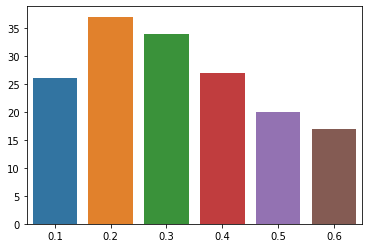

In [1503]:
import seaborn as sns
x = np.fromiter(tw.keys(), dtype = float)
y = np.fromiter(tw.values(), dtype = float)
sns.barplot(x, y);

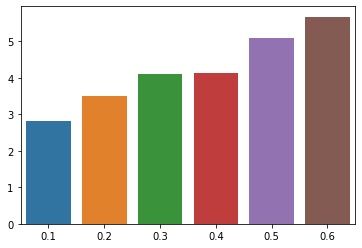

In [1504]:
x2 = np.fromiter(aw.keys(), dtype = float)
y2 = np.fromiter(aw.values(), dtype = float)
sns.barplot(x2, y2);

Average winnings goes up as your chance of taking every round increases, but the chance to win the entire game goes down
After running the simulation and looking at the graphs visually, the simulation is robust in that the average winnings w.r.t.
probability increases with probability but the 0.5 and 0.6 probabilities are usually always lower in total games won,
however the simulation is not robust in that the 0.1 - 0.4 total games won change a lot with respect to each other after each
simulation. There is a lot that could be done to create better visuals and clean up code.